In [1]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro
import torch
import VAE
import ConvEncoderDecoder as CED
import LinearEncoderDecoder as LED
import dataloader
from pyro.contrib.examples.util import MNIST
import torchvision.transforms as transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import numpy as np

In [79]:
USE_CUDA = False
NUM_EPOCHS = 20
TEST_FREQUENCY = 5
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

model = VAE.VAE(LED.LinearEncoder(2, 400, 100), LED.LinearDecoder(2, 400, 100))
#model = VAE.VAE(CED.ConvEncoder(2, 16), CED.ConvDecoder(2, 16))

optimizer = pyro.optim.Adam({'lr': 0.001})
svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 203.3777
[epoch 000] average test loss: 173.2468
[epoch 001]  average training loss: 169.9729
[epoch 002]  average training loss: 166.5053
[epoch 003]  average training loss: 165.0102
[epoch 004]  average training loss: 164.1534
[epoch 005]  average training loss: 163.6618
[epoch 005] average test loss: 163.8773
[epoch 006]  average training loss: 163.3531
[epoch 007]  average training loss: 163.1672
[epoch 008]  average training loss: 163.0712
[epoch 009]  average training loss: 162.9961
[epoch 010]  average training loss: 162.9583
[epoch 010] average test loss: 163.3825
[epoch 011]  average training loss: 162.9502
[epoch 012]  average training loss: 162.9294
[epoch 013]  average training loss: 162.9159
[epoch 014]  average training loss: 162.9179
[epoch 015]  average training loss: 162.9195
[epoch 015] average test loss: 163.3784
[epoch 016]  average training loss: 162.9143
[epoch 017]  average training loss: 162.9224


KeyboardInterrupt: 

In [66]:
from TrainedVAE import TrainedLinearVAE
from TrainedVAE import TrainedConvVAE
import torch
import numpy
import matplotlib.pyplot as plt

tensor(4)


<Figure size 640x480 with 0 Axes>

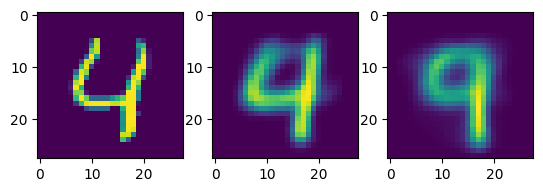

In [96]:
train_loader, test_loader = setup_data_loaders(batch_size=100, use_cuda=False)
inputs, classes = next(iter(test_loader)) 
z_mean, z_scale = TrainedLinearVAE.encoder(inputs)
z_mean2, z_scale2 = TrainedConvVAE.encoder(inputs)

k = 4
s = TrainedLinearVAE.decoder(z_mean[k]).detach().numpy().reshape(28, 28)
s2 = TrainedConvVAE.decoder(z_mean2[k]).detach().numpy().reshape(28, 28)
print(classes[k])

plt.figure()

f, ax = plt.subplots(1, 3)
ax[1].imshow(s)
ax[0].imshow(inputs[k].numpy().reshape(28, 28))
ax[2].imshow(s2)
plt.show()

In [104]:
train_loader, test_loader = setup_data_loaders(batch_size=60000, use_cuda=False)


<AxesSubplot: >

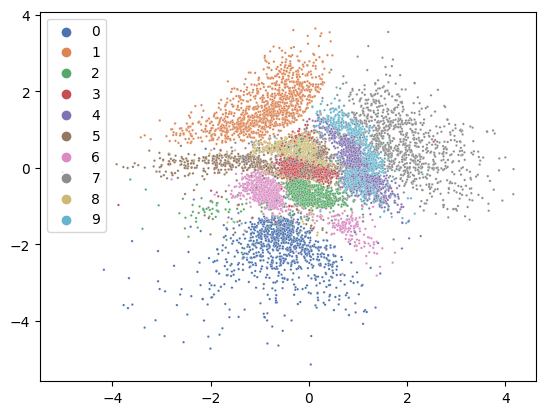

In [105]:
import seaborn as sns
inputs, classes = next(iter(test_loader)) 
z_mean, z_scale = TrainedLinearVAE.encoder(inputs)
c = classes.numpy()
z = z_mean.detach().numpy()
sns.scatterplot(x=z[:,0],y=z[:,1], hue=c, palette="deep", s = 3)